In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def str_to_float(number):
    '''
    Cette fonction permet de convertir un string en float
    Elle est nécessaire au vu de la façon dont sont écrits les nombres dans les fichiers csv
    Ex : '1234,56' -> 1234.56
    '''
    num = number.split(',')
    if len(num)==1 :
        return float(num[0])
    else :
        return (float(num[0]+'.'+num[1]))

str_to_float_v = np.vectorize(str_to_float) # Vectorisation de la fonction str_to_float

def time_to_float(ts):
    return sum(float(x) * 60 ** i for i, x in enumerate(reversed(ts.split(':'))))

time_to_float_v = np.vectorize(time_to_float) # Vectorisation de la fonction time_to_float

In [5]:
def new_name(path,ext):
    '''
    Cette fonction permet de renommer un fichier en changeant son extension
    Ex : 'C:\\Users\\user\\Desktop\\data.csv' -> 'C:\\Users\\user\\Desktop\\data.png'
    '''
    componants = path.split("\\")
    name = componants[-1]
    name2 = name[:-4]
    return (name2 + "." + ext)

In [6]:
def create_data(path,n,data_type = 'value'):
    '''
    Cette fonction retourne les données d'un fichier csv
    Elle retroune les données de la colonne n

    x : abscisses en numéro de balayage
    data_to_plot : nom de la donnée
    val : valeur des données en float ou time
    '''
    data = pd.read_csv(path, index_col="Bal", delimiter=";")
    columns = data.columns
    data_to_plot = columns[n]
    if data_type == 'value':
        val = str_to_float_v(data[data_to_plot].values)
    elif data_type == 'time':
        val = time_to_float_v(data[data_to_plot].values)
    x = np.arange(0,len(val))
    return x,data_to_plot,val

In [7]:
def plot_csv(path,n):
    '''
    Cette fonction permet de tracer les données d'un fichier csv présent en colonne n
    '''
    x,data_to_plot,val = create_data(path,n) # Récupération des données

    plt.figure()
    plt.plot(val)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    plt.grid()
    plt.savefig('Plot\\'+new_name(path,'png'))
    plt.show()

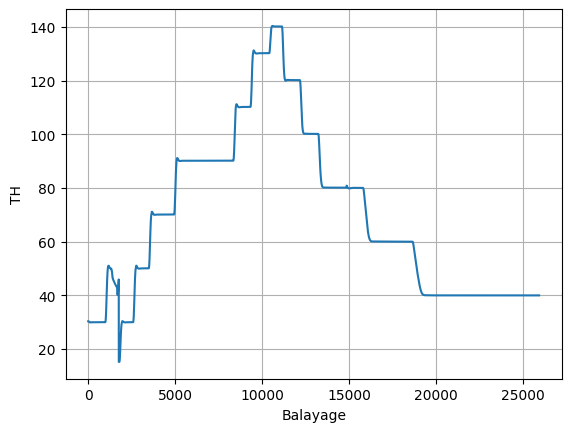

In [8]:
plot_csv("Data\\etal.csv",2)

In [9]:
def detect_stable_stage(path, precision=0.1, window_size=100, plot=False) :
    '''
    Cette fonction permet de détecter les paliers stables d'un fichier csv
    Elle retourne une matrice de taille (nb_stages,4) avec :
    - La première colonne : le début du palier (en numéro de balayage)
    - La deuxième colonne : la fin du palier (en numéro de balayage)
    - La troisième colonne : le début du palier (en temps)
    - La quatrième colonne : la fin du palier (en temps)
    - La cinquième colonne : la moyenne du palier
    - La sixième colonne : la variance du palier

    path : chemin du fichier csv
    precision : seuil de la variance pour détecter un palier
    window_size : taille de la fenêtre de calcul de la variance
    plot : booléen pour afficher le graphe de la variance
    '''
    x,data_to_plot,values = create_data(path,2) # Récupération des données
    x,data_to_plot,times = create_data(path,1,data_type='time') # Récupération des données

    n = len(values)
    variances = np.empty(n-window_size) # tableau des variances
    means = np.empty(n-window_size) # tableau des moyennes
    
    for i in range(n - window_size):
        window_data = values[i:i+window_size] # fenêtre de données
        var = np.var(window_data)
        mean = np.mean(window_data)
        variances[i] = var
        means[i] = mean
        
    points_stage = np.where(variances < precision)[0] 
    points_stage_by_stage = np.split(points_stage, np.where(np.diff(points_stage) != 1)[0]+1) # séparation des paliers
    nb_stages = len(points_stage_by_stage) # nombre de paliers

    stages_matrix = np.empty((nb_stages,6)) # matrice des paliers
    stages_matrix[:,0] = list(map(min,points_stage_by_stage))
    stages_matrix[:,1] = list(map(max,points_stage_by_stage))
    stages_matrix[:,2] = times[stages_matrix[:,0].astype(int)]
    stages_matrix[:,3] = times[stages_matrix[:,1].astype(int)]
    stages_matrix[:,4] = means[stages_matrix[:,0].astype(int)]
    stages_matrix[:,5] = variances[stages_matrix[:,0].astype(int)]

    if plot :
        plt.plot(variances)
        plt.plot([precision]*(n-window_size),'r')
        plt.ylabel('Variance')
    return stages_matrix

Une précision de l'ordre de $5.10^{-2}$ est en général suffisante pour calculer les paliers, c'est la taille de la fenêtre qu'il faut adapter en fonction des données que l'on a.
Plus on a de données et donc plus les paliers sont petits (comme sur refPVT), plus il faut augmenter la taille de la fenêtre.

array([[0.00000000e+00, 8.13000000e+02, 5.66480000e+04, 5.80770000e+04,
        3.00758200e+01, 2.36688976e-02],
       [1.92000000e+03, 2.41300000e+03, 4.27960000e+04, 4.36150000e+04,
        3.01060900e+01, 4.70515119e-02],
       [2.80100000e+03, 3.31300000e+03, 4.42590000e+04, 4.51100000e+04,
        5.01236700e+01, 4.92167411e-02],
       [3.70100000e+03, 4.77000000e+03, 4.57550000e+04, 4.75330000e+04,
        7.01745100e+01, 4.92459599e-02],
       [5.15800000e+03, 8.17900000e+03, 4.81780000e+04, 5.31990000e+04,
        9.02188750e+01, 4.85698294e-02],
       [8.56700000e+03, 9.16400000e+03, 5.38430000e+04, 5.48320000e+04,
        1.10241590e+02, 4.97696519e-02],
       [9.55500000e+03, 1.02490000e+04, 5.54740000e+04, 5.66140000e+04,
        1.30259300e+02, 4.99022900e-02],
       [1.05300000e+04, 1.09730000e+04, 5.70760000e+04, 5.78030000e+04,
        1.40186270e+02, 4.68569971e-02],
       [1.12970000e+04, 1.20090000e+04, 5.83360000e+04, 5.95060000e+04,
        1.20198645e+02, 

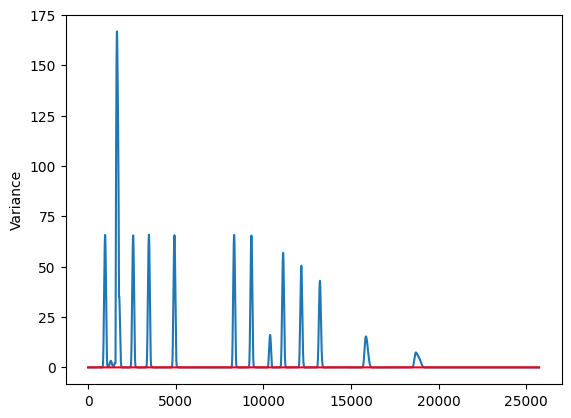

In [10]:
detect_stable_stage("Data\\etal.csv",precision=0.05,window_size=200,plot=True)

In [11]:
def stables_stage_plot(path,precision=0.1,window_size=100):
    '''
    Cette fonction permet de tracer les paliers stables d'un fichier csv
    '''
    x,data_to_plot,values = create_data(path,2) # Récupération des données
    x,time_to_plot,times = create_data(path,1,data_type='time') # Récupération des données

    stages_matrix = detect_stable_stage(path,precision,window_size) # Récupération des données

    plt.figure()
    plt.plot(values)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    for (start,end,start_time,end_time,mean,var) in stages_matrix :
        plt.plot(x[int(start):int(end)],mean*np.ones(int(end)-int(start)),'r')
        plt.grid()
    
    plt.show()


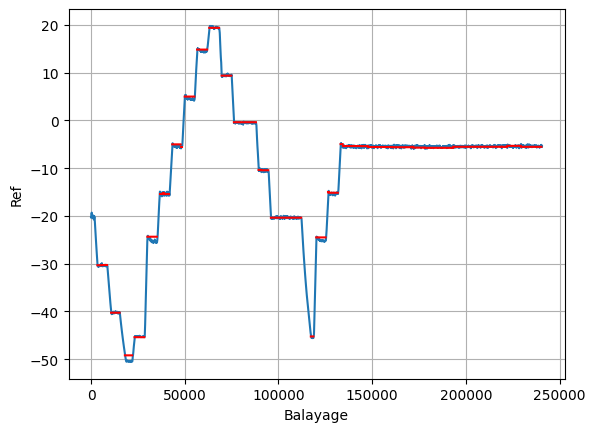

In [12]:
stables_stage_plot("Data\\refPVT.csv",precision=0.05,window_size=300)

In [13]:
def stables_stage_csv(path, precision=0.1, window_size=100):
    '''
    Cette fonction permet de retourne les paliers stables d'un fichier csv
    Elle retourne une dataframe de taille (nb_stages,4) avec :
    - La première colonne : le début du palier
    - La deuxième colonne : la fin du palier
    - La troisième colonne : le début du palier (en temps)
    - La quatrième colonne : la fin du palier (en temps)
    - La cinquièle colonne : la moyenne du palier
    - La sixième colonne : la variance du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    nb_stages = len(stages_matrix)
    ind = np.arange(nb_stages)
    df = pd.DataFrame(stages_matrix, index=ind, columns=['Debut (Bal)','Fin (Bal)','Debut (Temps)','Fin (Temps)','Moyenne','Variance'])
    df.to_csv('Plot\\mat_'+new_name(path,'csv'))
    return df

In [14]:
stables_stage_csv("Data\\refPVT.csv",precision=0.05,window_size=200)

,Debut (Bal),Fin (Bal),Debut (Temps),Fin (Temps),Moyenne,Variance
0,0.0,12.0,65556.0,65573.0,-20.165425,0.040489
1,141.0,274.0,65747.0,65926.0,-19.599855,0.049899
2,396.0,736.0,66091.0,66551.0,-20.053795,0.049435
3,794.0,1298.0,66629.0,67309.0,-20.245515,0.049619
4,1379.0,1746.0,67418.0,67913.0,-20.522975,0.049554
5,3361.0,8639.0,70092.0,77209.0,-30.208770,0.049488
6,10582.0,21988.0,79822.0,8788.0,-39.793495,0.049941
7,22129.0,22424.0,8978.0,9376.0,-49.626250,0.049794
8,22746.0,22906.0,9810.0,10026.0,-47.207180,0.049929
9,23167.0,28520.0,10378.0,17599.0,-45.560335,0.049981


In [15]:
def stables_stage_list(path, precision=0.1, window_size=100):
    '''
    Cette fonction donne les paliers stables d'un fichier csv sous forme de liste
    Elle retourne une liste de taille (nb_stages,2) avec :
    - La première colonne : la durée du palier (en sec)
    - La deuxième colonne : la moyenne du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    duree = stages_matrix[:,3] - stages_matrix[:,2]
    mean = stages_matrix[:,4]
    return list(zip(duree,mean))

In [16]:
stables_stage_list("Data\etal.csv",precision=0.05,window_size=10)

[(1746.0, 30.3666),
 (501.0, 49.5637),
 (10.0, 47.7271),
 (427.0, 46.7291),
 (72.0, 40.438100000000006),
 (87.0, 15.2239),
 (1164.0, 28.4673),
 (1303.0, 49.6288),
 (2232.0, 69.71960000000001),
 (5474.0, 89.71520000000001),
 (1439.0, 109.80429999999998),
 (1593.0, 129.7302),
 (1084.0, 137.8835),
 (1515.0, 122.10679999999999),
 (1546.0, 102.99170000000001),
 (2431.0, 83.95320000000001),
 (-21720.0, 80.7492),
 (10005.0, 73.7434)]

In [17]:
def polynomial_interpolation(x, y, degree):
    '''
    Cette fonction permet de faire une interpolation polynomiale
    Elle retourne le polynome d'interpolation
    '''
    poly = np.polynomial.polynomial.Polynomial.fit(x, y, degree, full=True)
    return poly

In [20]:
x,name,y1 = create_data("Data\Sondes.csv",2)
p = polynomial_interpolation(x,y1,1)
p

(Polynomial([ 75.85427546, -16.69125456], domain=[   0., 6646.], window=[-1.,  1.]),
 [array([5756610.99775954]), 2, array([1., 1.]), 1.4759304889366831e-12])

Le plot suivant n'est pas pertinent par rapport au projet mais nous l'avons gardé pour tester notre fonction d'interpolation.

TypeError: 'tuple' object is not callable

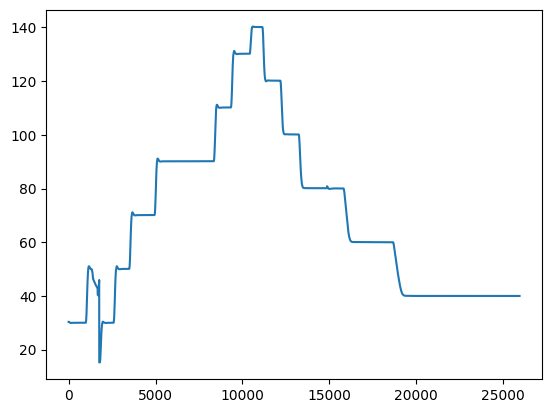

In [19]:
x,name,y = create_data("Data\etal.csv",2)
plt.figure()
# x_corrected = x[0:60000]
# y_corrected = y[0:60000]
plt.plot(x,y)
p = polynomial_interpolation(x,y,20)
z = p(x)
plt.plot(x,z)
plt.grid()
plt.show()


In [22]:
def linear_interpolation(x, y):
    """
    Cette fonction effectue une interpolation linéaire entre les données x et y
    """
    coeffs = np.polyfit(x, y, 1)
    return np.poly1d(coeffs)

La fonction suivante ne permet pour l'instant de comparer que des sondes issues d'un même fichier portant les numéros de colonne $n_1$ et $n_2$.

De plus, elle interpole pour l'instant avec la totalité des données et non avec les paliers.

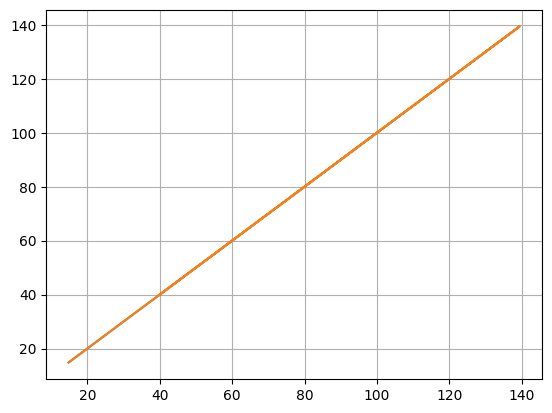

poly1d([ 1.00000000e+00, -3.02675333e-14])

In [23]:
def comparaison_sondes(n1,n2, graph = True):
    '''
    Cette fonction permet de comparer les sondes n1 et n2
    Elle retourne un graphe de comparaison si nécessaire
    '''
    x,name,y1 = create_data("Data\Sondes.csv",n1)
    x,name,y2 = create_data("Data\Sondes.csv",n2)
    p = linear_interpolation(y1,y2)
    z = p(y1)
    if graph :
        plt.figure()
        plt.plot(y1,y2)
        plt.plot(y1,z)
        plt.grid()
        plt.show()
    return p

p = comparaison_sondes(2,2)
p